# Gender Recognition by Voice Using Numerical Algorithms

## Importing Data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

sns.set(font_scale=1.5)

data = pd.read_csv('data/cleaned/voice_data.csv')
X_train = pd.read_csv('data/cleaned/X_train.csv')
y_train = pd.read_csv('data/cleaned/y_train.csv')
X_test = pd.read_csv('data/cleaned/X_test.csv')
y_test = pd.read_csv('data/cleaned/y_test.csv')

In [3]:
data.head()

,meanfreq,median,Q25,Q75,IQR,sd,log_skew,log_kurt,sp.ent,sfm,mode,meanfun,log_minfun,exp_maxfun,modindx,meandom,mindom,maxdom,dfrange,label
0,-4.049248,-4.224901,-2.576102,-5.693607,-0.214778,0.427355,2.925892,3.177486,-0.039083,0.471575,-2.141210,-1.812038,-1.384486,0.636793,-1.454772,-1.564205,-0.708404,-1.431422,-1.419137,male
1,-3.841053,-3.999293,-2.486885,-5.588987,-0.258485,0.611669,4.032721,4.022523,-0.065236,0.594431,-2.141210,-1.079594,-1.369352,-0.524133,-1.014103,-1.561916,-0.708404,-1.418107,-1.405818,male
2,-3.463066,-4.095851,-2.706986,-3.928699,0.909326,1.603848,4.675089,4.506253,-1.083730,0.398261,-2.141210,-1.365368,-1.390131,0.404082,-1.065344,-1.563866,-0.708404,-1.429203,-1.416917,male
3,-0.992157,-0.759454,-0.901418,-0.711205,0.632690,0.899998,-0.927599,-0.837709,1.516383,1.797340,-1.054576,-1.666966,-1.143909,-0.524133,0.614286,-1.195367,-0.708404,-1.273867,-1.261532,male
4,-1.530640,-1.676948,-1.268395,-0.792029,1.005588,1.322561,-1.055855,-0.807635,1.708336,2.114740,-0.790514,-1.127233,-1.239725,0.189238,0.289046,-0.221660,-0.708404,0.124154,0.136933,male


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   meanfreq    3168 non-null   float64
 1   median      3168 non-null   float64
 2   Q25         3168 non-null   float64
 3   Q75         3168 non-null   float64
 4   IQR         3168 non-null   float64
 5   sd          3168 non-null   float64
 6   log_skew    3168 non-null   float64
 7   log_kurt    3168 non-null   float64
 8   sp.ent      3168 non-null   float64
 9   sfm         3168 non-null   float64
 10  mode        3168 non-null   float64
 11  meanfun     3168 non-null   float64
 12  log_minfun  3168 non-null   float64
 13  exp_maxfun  3168 non-null   float64
 14  modindx     3168 non-null   float64
 15  meandom     3168 non-null   float64
 16  mindom      3168 non-null   float64
 17  maxdom      3168 non-null   float64
 18  dfrange     3168 non-null   float64
 19  label       3168 non-null  

The meaning of the features are as follows:

* `meanfreq`: mean frequency (in kHz)
* `median`: median frequency (in kHz)
* `Q25`: first quantile (in kHz)
* `Q75`: third quantile (in kHz)
* `IQR`: inter-quantile range (in kHz)
* `sd`: standard deviation of frequency
* `log_skew`: skewness after logarithmic transformation
* `log_kurt`: kurtosis after logarithmic transformation
* `sp.ent`: spectral entropy
* `sfm`: spectral flatness
* `mode`: mode frequency
* `log_meanfun`: average of fundamental frequency measured across acoustic signal
* `log_minfun`: minimum fundamental frequency measured across acoustic signal after logarithmic transformation
* `exp_maxfun`: maximum fundamental frequency measured across acoustic signal after exponential transformation
* `modindx`: modulation index
* `meandom`: average of dominant frequency measured across acoustic signal
* `mindom`: minimum of dominant frequency measured across acoustic signal
* `maxdom`: maximum of dominant frequency measured across acoustic signal
* `dfrange`: range of dominant frequency measured across acoustic signal
* `label`: male or female

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

class CombinedMethod(object):
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.rfClassifier = RandomForestClassifier(random_state=87).fit(X_train, y_train.squeeze())
        self.svmClassifier = SVC(random_state=87, kernel="rbf", gamma=0.01, C=10).fit(X_train, y_train.squeeze())
        self.mlpClassifier = MLPClassifier(random_state=87, max_iter=1000, hidden_layer_sizes=(100, 100, 100, 100)).fit(X_train, y_train.squeeze())

    def get_all_predictions(self, X):
        rf_predictions = self.rfClassifier.predict(X)
        svm_predictions = self.svmClassifier.predict(X)
        mlp_predictions = self.mlpClassifier.predict(X)
        return rf_predictions, svm_predictions, mlp_predictions

    def predict(self, X):
        rf_predictions = self.rfClassifier.predict(X)
        svm_predictions = self.svmClassifier.predict(X)
        mlp_predictions = self.mlpClassifier.predict(X)
        predictions = []
        for i in range(len(X)):
            predictions.append(np.argmax(np.bincount([rf_predictions[i], svm_predictions[i], mlp_predictions[i]])))
        return predictions

    def score(self, X, y):
        predictions = self.predict(X)
        return np.sum(predictions == y.squeeze()) / len(y)

    def score_all(self, X, y):
        rf_score = self.rfClassifier.score(X, y.squeeze())
        svm_score = self.svmClassifier.score(X, y.squeeze())
        mlp_score = self.mlpClassifier.score(X, y.squeeze())
        combined_score = self.score(X, y)
        return rf_score, svm_score, mlp_score, combined_score

In [11]:
y_train_clean = y_train == "male"
y_test_clean = y_test == "male"
combinedMethod = CombinedMethod(X_train, y_train_clean)
print("Train Set Scores:", combinedMethod.score(X_train, y_train_clean))
print("Test Set Scores:", combinedMethod.score(X_test, y_test_clean))

Train Set Scores: 1.0
Test Set Scores: 0.9800664451827242


In [7]:
combinedMethod.score_all(X_test, y_test_clean)

(0.9800664451827242, 0.9651162790697675, 0.973421926910299, 0.9767441860465116)

In [8]:
rf_predictions, svm_predictions, mlp_predictions = combinedMethod.get_all_predictions(X_test)
rf_accuracy = y_test_clean.squeeze() == rf_predictions
svm_accuracy = y_test_clean.squeeze() == svm_predictions
mlp_accuracy = y_test_clean.squeeze() == mlp_predictions
(rf_accuracy | svm_accuracy | mlp_accuracy != rf_accuracy).sum()

5

## Conclusion

| Model | Training Accuracy | Testing Accuracy |
| --- | --- | --- |
| Classification Tree | 1.0000 | 0.9751 |
| Random Forest | 1.0000 | 0.9801 |
| Logistic Regression | 0.9763 | 0.9734 |
| K-Nearest Neighbors | 1.0000 | 0.9817 |
| Support Vector Machine | 0.9896 | 0.9834 |
| Multi-Layer Perceptron | 1.0000 | 0.9734 |
| Ensemble Vote | 1.0000 | 0.9800 |

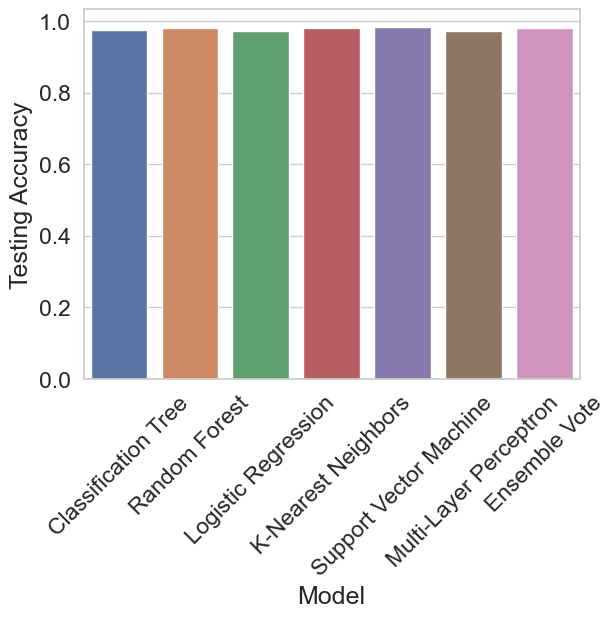

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the data
data = {
    'Model': ['Classification Tree', 'Random Forest', 'Logistic Regression', 'K-Nearest Neighbors', 
              'Support Vector Machine', 'Multi-Layer Perceptron', 'Ensemble Vote'],
    'Training Accuracy': [1.0000, 1.0000, 0.9763, 1.0000, 0.9896, 1.0000, 1.0000],
    'Testing Accuracy': [0.9751, 0.9801, 0.9734, 0.9817, 0.9834, 0.9734, 0.9800]
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Define the plot style
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(x='Model', y='Testing Accuracy', data=df)

# Set the plot labels
ax.set(xlabel='Model', ylabel='Testing Accuracy')

# Rotate the x-axis labels to avoid overlapping
ax.set_xticklabels(df['Model'], rotation=45)

# Show the plot
plt.show()

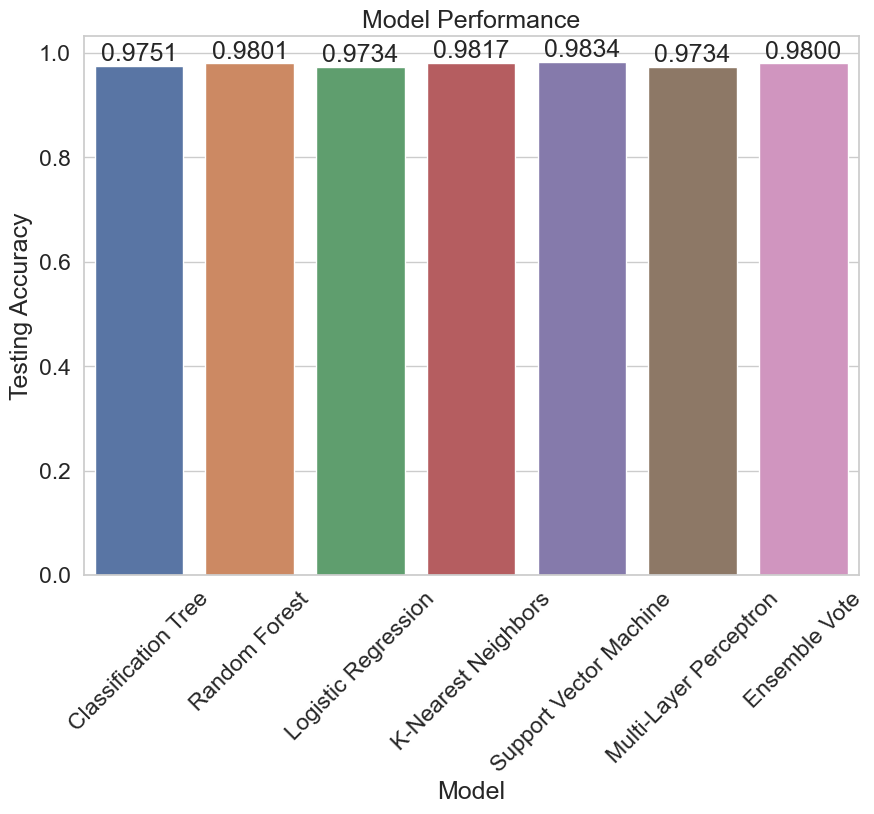

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# Define the data
data = {
    'Model': ['Classification Tree', 'Random Forest', 'Logistic Regression', 'K-Nearest Neighbors', 
              'Support Vector Machine', 'Multi-Layer Perceptron', 'Ensemble Vote'],
        'Training Accuracy': [1.0000, 1.0000, 0.9763, 1.0000, 0.9896, 1.0000, 1.0000],
        'Testing Accuracy': [0.9751, 0.9801, 0.9734, 0.9817, 0.9834, 0.9734, 0.9800]}

# Convert the data to a pandas DataFrame
results = pd.DataFrame(data)

# Set the style
sns.set_style('whitegrid')

# Create the barplot
ax = sns.barplot(x='Model', y='Testing Accuracy', data=results)

# Add labels to the bars
for i in range(len(results)):
    ax.annotate(f"{results['Testing Accuracy'][i]:.4f}", (i, results['Testing Accuracy'][i]), ha='center', va='bottom')

# Add a title
plt.title('Model Performance')

# Rotate the x-axis labels to avoid overlapping
ax.set_xticklabels(data['Model'], rotation=45)

# Show the plot
plt.show()